In [57]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

from matplotlib import rc, font_manager
rc('font', family='NanumGothic')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn import preprocessing

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import accuracy_score 


import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")

import mglearn
import seaborn as sns

from sklearn.preprocessing import StandardScaler

import random
import json
import folium

import math
from math import radians, sin,cos,atan2,sqrt

import scipy
import scipy.cluster.hierarchy as sch

## 몇 개의 수소 충전소?

In [837]:
# 1. 수소자동차 대수를 입력받는다. 
hydrogen_car = input("Enter the num of hydrogen car : ")

# 2. 수소자동차 대수를 기반으로 hybrid 충전소의 개수 K를 구한다. 
total_charge_needed = 200 * int(hydrogen_car) # 총 필요 충전량
total_charge_needed -= 237600
if total_charge_needed <0:
    total_charge_needed = 0
num_of_hybrid = math.floor(total_charge_needed / 142560) # hybrid 충전소 개수
num_of_converged = num_of_hybrid # 융복합충전소 개수
num_of_mobile = 3 * num_of_converged # 이동식 충전소 개수
num_of_off_site = math.floor(total_charge_needed / 57520) # 필요한 off_site 개수

print("hybrid충전소 개수 : ", num_of_hybrid)
print("이동식 충전소 개수", num_of_mobile)

Enter the num of hydrogen car : 300000
hybrid충전소 개수 :  419
이동식 충전소 개수 1257


## 충전소를 세울 시 어느 동을 추천?

In [ ]:
data_total_gas_pk = pd.read_csv('data_total_final.csv')

In [245]:
data_total_gas_pk = pd.read_csv('dataset_interval1_interval2.csv')

In [285]:
data_total_lpg_1.to_csv('data_total_lpg_hy.csv')

In [752]:
# 지도에 보이기 
geo_path = "geoData_copy.json"
geo_str = json.load(open(geo_path, encoding="utf-8"))

seoul_map = folium.Map(location=[37.5502, 126.982], zoom_start=10.5, tiles="cartodbpositron")
seoul_map.choropleth(geo_data=geo_str, 
                     data = data_total_lpg_1 ,
                     columns=['동', 'sum_2'],
                     fill_color='RdPu',  # GnBu
                     key_on='properties.name',
                     highlight=True,
                     fill_opacity=0.5,
                     line_opacity=1,
                     legend_name="sum1")
# 양재 수소충전소를 찍어보자.
folium.Marker(
  location=[37.4686275,127.0319203],
  popup='양재 수소 충전소 위치.',
  icon=folium.Icon(color='red',icon='star')
).add_to(seoul_map)

# 상암 수소 충전소를 찍어보자.
folium.Marker(
  location=[37.5687204,126.8761933],
  popup='상암 수소 충전소 위치.',
  icon=folium.Icon(color='red',icon='star')
).add_to(seoul_map)

# 국회 수소 충전소를 찍어보자.
folium.Marker(
  location=[37.5311111,126.9132037],
  popup='2019년 완공 예정 국회 수소 충전소 위치.',
  icon=folium.Icon(color='blue',icon='star')
).add_to(seoul_map)

# 강동구 상일충전소를 찍어보자.
folium.Marker(
  location=[37.5392486,127.128611],
  popup='2019년 완공 예정 강동구 상일충전소 위치',
  icon=folium.Icon(color='blue',icon='star')
).add_to(seoul_map)

def top_dong(hybrid=2):
    data_gas=data_total_lpg_1[['자치구', '동','sum_2', 'interval_1', '수소충전소', '업체명', '동주소', '경도', '위도' ]]
    data_gas.drop_duplicates(subset ="업체명", keep = 'first', inplace=True)
    data_gas.dropna(inplace=True)

    # 수소충전소가 이미 있는 지역은 제외
    indexexist = data_gas[(data_gas['자치구'].isin(data_gas[(data_gas['수소충전소']==1)].자치구))].index
    data_gas.drop(indexexist, inplace=True)

    # 중첩분석 8등급 이상인 주유소만 가져오기 
    data_gas=data_gas[(data_gas['interval_1']>7)]
    data_gas.reset_index(drop=True, inplace=True)

    # 거리구하기

    import numbers
    import math

    class GeoUtil:
        @staticmethod
        def get_euclidean_distance(x1, y1, x2, y2, round_decimal_digits=5):        
            """
            유클리안 Formula 이용하여 (x1,y1)과 (x2,y2) 점의 거리를 반환
            """
            if x1 is None or y1 is None or x2 is None or y2 is None:
                return None
            assert isinstance(x1, numbers.Number) and -180 <= x1 and x1 <= 180
            assert isinstance(y1, numbers.Number) and  -90 <= y1 and y1 <=  90
            assert isinstance(x2, numbers.Number) and -180 <= x2 and x2 <= 180
            assert isinstance(y2, numbers.Number) and  -90 <= y2 and y2 <=  90

            dLon = abs(x2-x1) # 경도 차이
            if dLon >= 180:   # 반대편으로 갈 수 있는 경우
                dLon -= 360   # 반대편 각을 구한다
            dLat = y2-y1      # 위도 차이
            return round(math.sqrt(pow(dLon,2)+pow(dLat,2)),round_decimal_digits)
    
    # 거리 2dim넣기
    dist = [[0 for i in range(len(data_gas))] for j in range(len(data_gas))]

    for i in range(len(data_gas)):
        for j in range(len(data_gas)):
            dist[i][j] = GeoUtil.get_euclidean_distance(data_gas.iloc[i,8],data_gas.iloc[i,7],data_gas.iloc[j,8],data_gas.iloc[j,7])
    # 군집분석 - 그래프
    import scipy.cluster.hierarchy as shc
    plt.figure(figsize=(10, 7))
    plt.title("Customer Dendograms")
    dend = shc.dendrogram(shc.linkage(dist, method='single'))
    
    # 군집분석하기
    from sklearn.cluster import AgglomerativeClustering

    cluster = AgglomerativeClustering(n_clusters=hybrid, affinity='euclidean', linkage='single')
    cluster.fit_predict(dist)

    data_gas['sing_clus']=pd.DataFrame(cluster.fit_predict(dist))

    sing_top_dong=data_gas.groupby(['sing_clus','자치구','동','업체명']).agg({'sum_2':'mean','interval_1':'mean'})
    
    sing_index=sing_top_dong.sort_values(by='sum_2', ascending=False).groupby('sing_clus').head(1)
    print(sing_index)
    
    # top 업체명 list 뽑기
    top_lpg = sing_index.index.get_level_values('업체명').tolist()
    top_data = data_gas[(data_gas.업체명.isin(top_lpg))]


    # 추천 lpg 주유소 보이기
    top_data.reset_index(drop=True, inplace=True)
    for i in range(len(top_data)):
        folium.Marker(
            location=top_data.loc[i,['경도','위도']],
            popup=top_data.loc[i,['동']],
            icon=folium.Icon(color='lightgray',icon='home')
        ).add_to(seoul_map)
    seoul_map
    seoul_map.save("seoul_map.html")

C:\Users\Cho Gyung Ah\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Cho Gyung Ah\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Cho Gyung Ah\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Cho Gyung Ah\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: ClusterWarning: scipy.cluster: The s

                                        sum_2  interval_1
sing_clus 자치구  동     업체명                                 
0         강남구  세곡동   (주)수서에너지        4.515051          10
6         강남구  논현2동  (주)상현상사         3.283231          10
1         양천구  신정3동  수도에너지(주)        2.570892          10
7         구로구  오류2동  대성산업(주)오류동충전소   2.066541          10
5         동작구  사당1동  수도석유(주)방배충전소    1.908866           8
4         은평구  진관동   은평서부충전소         1.884689          10
3         서대문구 북가좌1동 연일가스산업(주)       1.258378          10
8         동대문구 휘경1동  수도에너지(주)동서울충전소  0.769751          10
2         강북구  번1동   서울와사공업(주)       0.613759          10


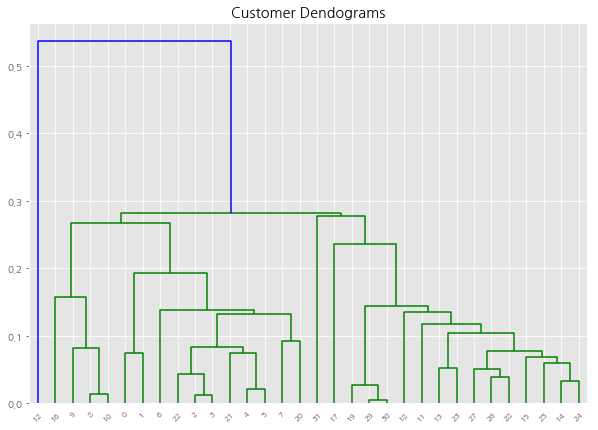

In [753]:
top_dong(9)

C:\Users\Cho Gyung Ah\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Cho Gyung Ah\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Cho Gyung Ah\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Cho Gyung Ah\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: ClusterWarning: scipy.cluster: T

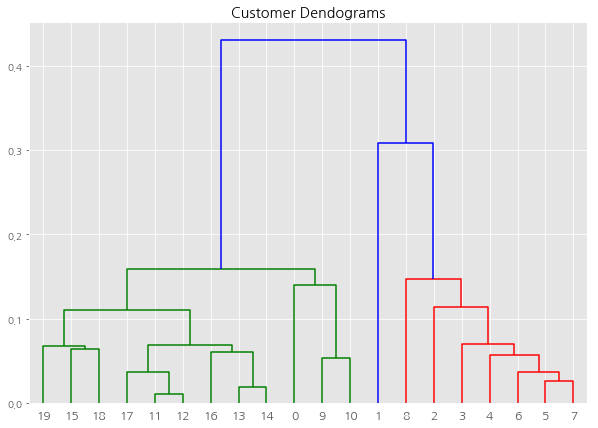

In [706]:
data_total_gas_pk = pd.read_csv('data_total_final.csv')

data_gas=data_total_gas_pk[['자치구', '동','sum1', 'sum_clus','총_점수_interval_10', '수소충전소', '업체명', '동주소', '경도', '위도' ]]

data_gas.drop_duplicates(subset ="업체명", 
                     keep = 'first', inplace=True)

data_gas.dropna(inplace=True)

# 수소충전소가 이미 있는 지역은 제외
indexexist = data_gas[(data_gas['자치구'].isin(data_gas[(data_gas['수소충전소']==1)].자치구))].index
data_gas.drop(indexexist, inplace=True)

# 중첩분석 8등급 이상인 주유소만 가져오기 
data_gas=data_gas[(data_gas['총_점수_interval_10']>7)]

data_gas.reset_index(drop=True, inplace=True)

# 거리구하기

import numbers
import math

class GeoUtil:
    @staticmethod
    def get_euclidean_distance(x1, y1, x2, y2, round_decimal_digits=5):        
        """
        유클리안 Formula 이용하여 (x1,y1)과 (x2,y2) 점의 거리를 반환
        """
        if x1 is None or y1 is None or x2 is None or y2 is None:
            return None
        assert isinstance(x1, numbers.Number) and -180 <= x1 and x1 <= 180
        assert isinstance(y1, numbers.Number) and  -90 <= y1 and y1 <=  90
        assert isinstance(x2, numbers.Number) and -180 <= x2 and x2 <= 180
        assert isinstance(y2, numbers.Number) and  -90 <= y2 and y2 <=  90

        dLon = abs(x2-x1) # 경도 차이
        if dLon >= 180:   # 반대편으로 갈 수 있는 경우
            dLon -= 360   # 반대편 각을 구한다
        dLat = y2-y1      # 위도 차이
        return round(math.sqrt(pow(dLon,2)+pow(dLat,2)),round_decimal_digits)

dist = [[0 for i in range(len(data_gas))] for j in range(len(data_gas))]

for i in range(len(data_gas)):
    for j in range(len(data_gas)):
        dist[i][j] = GeoUtil.get_euclidean_distance(data_gas.iloc[i,9],data_gas.iloc[i,8],data_gas.iloc[j,9],data_gas.iloc[j,8])

import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(dist, method='single'))

from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='single')
cluster.fit_predict(dist)

data_gas['sing_clus']=pd.DataFrame(cluster.fit_predict(dist))

sing_top_dong=data_gas.groupby(['sing_clus','자치구','동','업체명']).agg({'sum1':'mean','총_점수_interval_10':'mean'})

sing_index=sing_top_dong.sort_values(by='sum1', ascending=False).groupby('sing_clus').head(1)

top_lpg = sing_index.index.get_level_values('업체명').tolist()

top_data = data_gas[(data_gas.업체명.isin(top_lpg))]

top_data.iloc[:,8]

geo_path = "geoData_copy.json"
geo_str = json.load(open(geo_path, encoding="utf-8"))

seoul_map = folium.Map(location=[37.5502, 126.982], zoom_start=10.5, tiles="cartodbpositron")
seoul_map.choropleth(geo_data=geo_str, 
                     data = data_total_gas_pk ,
                     columns=['동', 'sum1'],
                     fill_color='RdPu',  # GnBu
                     key_on='properties.name',
                     highlight=True,
                     fill_opacity=0.5,
                     line_opacity=1,
                     legend_name="sum1")
seoul_map.save("size.html")

top_data.reset_index(drop=True, inplace=True)

for i in range(len(top_data)):
    folium.Marker(
        location=top_data.loc[i,['경도','위도']],
        popup=top_data.loc[i,['동']],
        icon=folium.Icon(color='lightgray',icon='home')
    ).add_to(seoul_map)

# 양재 수소충전소를 찍어보자.
folium.Marker(
  location=[37.4686275,127.0319203],
  popup='양재 수소 충전소 위치.',
  icon=folium.Icon(color='red',icon='star')
).add_to(seoul_map)

# 상암 수소 충전소를 찍어보자.
folium.Marker(
  location=[37.5687204,126.8761933],
  popup='상암 수소 충전소 위치.',
  icon=folium.Icon(color='red',icon='star')
).add_to(seoul_map)

# 국회 수소 충전소를 찍어보자.
folium.Marker(
  location=[37.5311111,126.9132037],
  popup='2019년 완공 예정 국회 수소 충전소 위치.',
  icon=folium.Icon(color='blue',icon='star')
).add_to(seoul_map)

# 강동구 상일충전소를 찍어보자.
folium.Marker(
  location=[37.5392486,127.128611],
  popup='2019년 완공 예정 강동구 상일충전소 위치',
  icon=folium.Icon(color='blue',icon='star')
).add_to(seoul_map)

seoul_map

# 주차장 - 노선 위치 선정 

In [819]:
data_total_gas_pk = pd.read_csv('data_total_final.csv')

def parking(hybrid=2, pk=3):
    df_parking=data_total_gas_pk[[ '자치구', '동', 'sum1', 'sum_clus', '총_점수_interval_10',  '수소충전소',
                       '주차장명', '주차장구분', '주차장유형', '주차구획수', '주차급지구분', '주차부제시행구분', '주차운영요일',
           '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각', '토요일운영종료시각', '주차요금정보', '주차기본시간',
           '주차기본요금', '주차경도', '주차위도' ]]
    df_parking.drop_duplicates(subset ="주차장명", 
                         keep = 'first', inplace=True)

    # 중첩 6등급 이상인 애들만 가져오기
    data_parking = df_parking[(df_parking.총_점수_interval_10>5)]

    data_parking.dropna(inplace=True)

    # 수소 충전소 있는 애들 빼기
    indexexist = data_parking[(data_parking['자치구'].isin(data_parking[(data_parking['수소충전소']==1)].자치구))].index
    data_parking.drop(indexexist, inplace=True)

    # 수소 충전소 개질기 추천된 애들 빼기
    data_parking = data_parking[~(data_parking.자치구.isin(top_data.자치구))]

    # 개질기 와의 거리 군집
    dist = [[0 for i in range(len(data_parking))] for j in range(len(top_data))]

    top_data.reset_index(drop=True, inplace=True)
    data_parking.reset_index(drop=True, inplace=True)

    for i in range(len(top_data)):
        for j in range(len(data_parking)):
            dist[i][j] = GeoUtil.get_euclidean_distance(top_data.loc[i,'위도'],top_data.loc[i,'경도'],data_parking.loc[j,'주차경도'],data_parking.loc[j,'주차위도'])

    dis= pd.DataFrame(dist).T

    import scipy.cluster.hierarchy as shc
    plt.figure(figsize=(10, 7))
    plt.title("average Dendograms")
    dend = shc.dendrogram(shc.linkage(dis, method='average'))

    from sklearn.cluster import AgglomerativeClustering

    cluster = AgglomerativeClustering(n_clusters=hybrid * pk, affinity='euclidean', linkage='average')
    cluster.fit_predict(dis)

    data_parking['avg_clus']=pd.DataFrame(cluster.fit_predict(dis))

    comp_top_parking=data_parking.groupby(['avg_clus','자치구','동','주차장명']).agg({'sum1':'mean','총_점수_interval_10':'mean'})

    comp_index=comp_top_parking.sort_values(by='sum1', ascending=False).groupby('avg_clus').head(1)

    top_pk_index = comp_index.index.get_level_values('주차장명').tolist()

    top_parking = data_parking[(data_parking.주차장명.isin(top_pk_index))]

    geo_path = "geoData_copy.json"
    geo_str = json.load(open(geo_path, encoding="utf-8"))

    seoul_map = folium.Map(location=[37.5502, 126.982], zoom_start=10.5, tiles="cartodbpositron")
    seoul_map.choropleth(geo_data=geo_str, 
                         data = data_total_gas_pk ,
                         columns=['동', 'sum1'],
                         fill_color='RdPu',  # GnBu
                         key_on='properties.name',
                         highlight=True,
                         fill_opacity=0.5,
                         line_opacity=1,
                         legend_name="sum1")

    top_parking.reset_index(drop=True, inplace=True)

    for i in range(len(top_parking)):
        folium.Marker(
            location=top_parking.loc[i,['주차위도','주차경도']],
            popup=top_parking.loc[i,['주차장명']],
            icon=folium.Icon(color='gray')
        ).add_to(seoul_map)

    for i in range(len(top_data)):
        folium.Marker(
            location=top_data.loc[i,['경도','위도']],
            popup=top_data.loc[i,['동']],
            icon=folium.Icon(color='lightgray',icon='home')
        ).add_to(seoul_map)


    seoul_map.save("seoul_map.html")
    seoul_map

C:\Users\Cho Gyung Ah\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Cho Gyung Ah\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Cho Gyung Ah\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Cho Gyung Ah\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWar

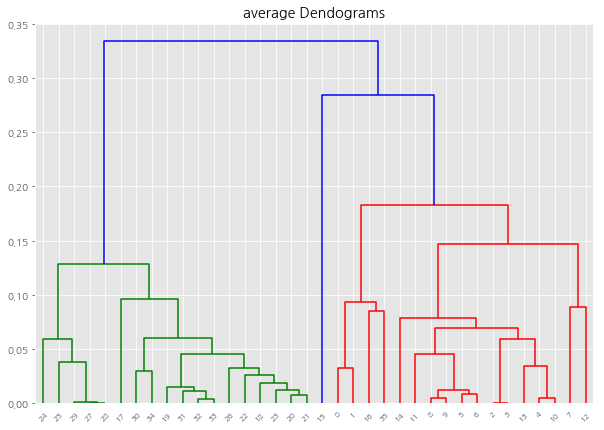

In [822]:
parking(3)

In [754]:
data_total_gas_pk = pd.read_csv('data_total_final.csv')

In [755]:
df_parking=data_total_gas_pk[[ '자치구', '동', 'sum1', 'sum_clus', '총_점수_interval_10',  '수소충전소',
                   '주차장명', '주차장구분', '주차장유형', '주차구획수', '주차급지구분', '주차부제시행구분', '주차운영요일',
       '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각', '토요일운영종료시각', '주차요금정보', '주차기본시간',
       '주차기본요금', '주차경도', '주차위도' ]]

In [756]:
df_parking.drop_duplicates(subset ="주차장명", 
                     keep = 'first', inplace=True)

C:\Users\Cho Gyung Ah\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [757]:
# 중첩 6등급 이상인 애들만 가져오기
data_parking = df_parking[(df_parking.총_점수_interval_10>5)]

In [758]:
data_parking.dropna(inplace=True)

C:\Users\Cho Gyung Ah\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [759]:
# 수소 충전소 있는 애들 빼기
indexexist = data_parking[(data_parking['자치구'].isin(data_parking[(data_parking['수소충전소']==1)].자치구))].index
data_parking.drop(indexexist, inplace=True)

C:\Users\Cho Gyung Ah\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [760]:
# 수소 충전소 개질기 추천된 애들 빼기
data_parking = data_parking[~(data_parking.자치구.isin(top_data.자치구))]

In [761]:
import numbers
import math

class GeoUtil:
    @staticmethod
    def get_euclidean_distance(x1, y1, x2, y2, round_decimal_digits=5):        
        """
        유클리안 Formula 이용하여 (x1,y1)과 (x2,y2) 점의 거리를 반환
        """
        if x1 is None or y1 is None or x2 is None or y2 is None:
            return None
        assert isinstance(x1, numbers.Number) and -180 <= x1 and x1 <= 180
        assert isinstance(y1, numbers.Number) and  -90 <= y1 and y1 <=  90
        assert isinstance(x2, numbers.Number) and -180 <= x2 and x2 <= 180
        assert isinstance(y2, numbers.Number) and  -90 <= y2 and y2 <=  90

        dLon = abs(x2-x1) # 경도 차이
        if dLon >= 180:   # 반대편으로 갈 수 있는 경우
            dLon -= 360   # 반대편 각을 구한다
        dLat = y2-y1      # 위도 차이
        return round(math.sqrt(pow(dLon,2)+pow(dLat,2)),round_decimal_digits)

## 개질기 와의 거리 군집

In [762]:
dist = [[0 for i in range(len(data_parking))] for j in range(len(top_data))]

In [763]:
top_data.reset_index(drop=True, inplace=True)
data_parking.reset_index(drop=True, inplace=True)

In [764]:
for i in range(len(top_data)):
    for j in range(len(data_parking)):
        dist[i][j] = GeoUtil.get_euclidean_distance(top_data.loc[i,'위도'],top_data.loc[i,'경도'],data_parking.loc[j,'주차경도'],data_parking.loc[j,'주차위도'])

In [765]:
dis= pd.DataFrame(dist).T

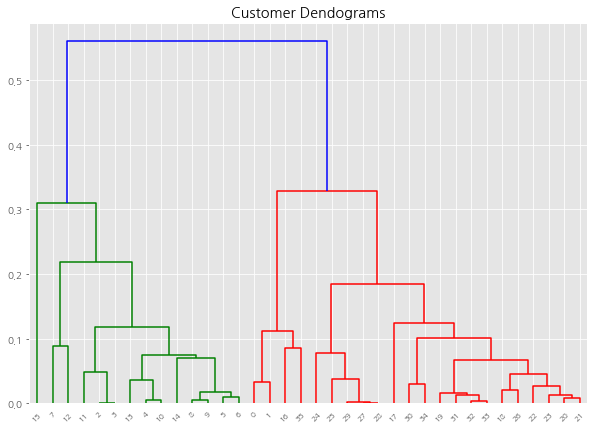

In [766]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(dis, method='complete'))

In [811]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=20, affinity='euclidean', linkage='average')
cluster.fit_predict(dis)

data_parking['avg_clus']=pd.DataFrame(cluster.fit_predict(dis))

In [812]:
comp_top_parking=data_parking.groupby(['avg_clus','자치구','동','주차장명']).agg({'sum1':'mean','총_점수_interval_10':'mean'})

comp_index=comp_top_parking.sort_values(by='sum1', ascending=False).groupby('avg_clus').head(1)

In [813]:
top_pk_index = comp_index.index.get_level_values('주차장명').tolist()

In [814]:
top_parking = data_parking[(data_parking.주차장명.isin(top_pk_index))]

In [815]:
geo_path = "geoData_copy.json"
geo_str = json.load(open(geo_path, encoding="utf-8"))

seoul_map = folium.Map(location=[37.5502, 126.982], zoom_start=10.5, tiles="cartodbpositron")
seoul_map.choropleth(geo_data=geo_str, 
                     data = data_total_gas_pk ,
                     columns=['동', 'sum1'],
                     fill_color='RdPu',  # GnBu
                     key_on='properties.name',
                     highlight=True,
                     fill_opacity=0.5,
                     line_opacity=1,
                     legend_name="sum1")

C:\Users\Cho Gyung Ah\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [816]:
top_parking.reset_index(drop=True, inplace=True)

In [817]:
for i in range(len(top_parking)):
    folium.Marker(
        location=top_parking.loc[i,['주차위도','주차경도']],
        popup=top_parking.loc[i,['주차장명']],
        icon=folium.Icon(color='gray')
    ).add_to(seoul_map)
    
for i in range(len(top_data)):
    folium.Marker(
        location=top_data.loc[i,['경도','위도']],
        popup=top_data.loc[i,['동']],
        icon=folium.Icon(color='lightgray',icon='home')
    ).add_to(seoul_map)


# 양재 수소충전소를 찍어보자.
folium.Marker(
  location=[37.4686275,127.0319203],
  popup='양재 수소 충전소 위치.',
  icon=folium.Icon(color='red',icon='star')
).add_to(seoul_map)

# 상암 수소 충전소를 찍어보자.
folium.Marker(
  location=[37.5687204,126.8761933],
  popup='상암 수소 충전소 위치.',
  icon=folium.Icon(color='red',icon='star')
).add_to(seoul_map)

# 국회 수소 충전소를 찍어보자.
folium.Marker(
  location=[37.5311111,126.9132037],
  popup='2019년 완공 예정 국회 수소 충전소 위치.',
  icon=folium.Icon(color='blue',icon='star')
).add_to(seoul_map)

# 강동구 상일충전소를 찍어보자.
folium.Marker(
  location=[37.5392486,127.128611],
  popup='2019년 완공 예정 강동구 상일충전소 위치',
  icon=folium.Icon(color='blue',icon='star')
).add_to(seoul_map)

# 강서공영차고지 수소생산기지 찍어보자.
folium.Marker(
  location=[37.5775641,126.7963879],
  popup=' 2020년 완공 예정 강서공영차고지 수소생산기지 버스용',
  icon=folium.Icon(color='green',icon='star')
).add_to(seoul_map)

# 탄천물재생센터 수소춘전소 찍어보자.
folium.Marker(
  location=[37.4915688,127.0671297],
  popup=' 2020년 완공 예정이지만 미정 탄천물재생센터 수소춘전소',
  icon=folium.Icon(color='green',icon='star')
).add_to(seoul_map)

# 현대자동차 계동사옥 수소춘전소 찍어보자.
folium.Marker(
  location=[37.566758,126.9584211],
  popup=' 아직 미정 현대자동차 계동사옥 수소춘전소',
  icon=folium.Icon(color='green',icon='star')
).add_to(seoul_map)

seoul_map.save("seoul_map.html")
seoul_map

# 거리 가까운 3개 

In [823]:
dis= pd.DataFrame(dist).T

In [824]:
dis.shape[1]

10

In [825]:
d = []
for i in range(dis.shape[1]):
    d.append(dis.iloc[:,i].nsmallest(3))

In [826]:
dis.iloc[:,3].nsmallest(3)

24    0.02343
27    0.02613
28    0.02613
Name: 3, dtype: float64

In [827]:
pick= pd.DataFrame(d).T.index

In [828]:
df_pick = data_parking.iloc[pick,:]

In [829]:
geo_path = "geoData_copy.json"
geo_str = json.load(open(geo_path, encoding="utf-8"))

seoul_map = folium.Map(location=[37.5502, 126.982], zoom_start=10.5, tiles="cartodbpositron")
seoul_map.choropleth(geo_data=geo_str, 
                     data = data_total_gas_pk ,
                     columns=['동', 'sum1'],
                     fill_color='RdPu',  # GnBu
                     key_on='properties.name',
                     highlight=True,
                     fill_opacity=0.5,
                     line_opacity=1,
                     legend_name="sum1")

In [830]:
top_pk_index = comp_index.index.get_level_values('주차장명').tolist()

In [831]:
top_parking = data_parking[(data_parking.주차장명.isin(top_pk_index))]

In [832]:
df_pick.reset_index(drop=True, inplace=True)

In [833]:
for i in range(len(df_pick)):
    folium.Marker(
        location=df_pick.loc[i,['주차위도','주차경도']],
        popup=df_pick.loc[i,['동']],
        icon=folium.Icon(color='gray')
    ).add_to(seoul_map)

for i in range(len(top_data)):
    folium.Marker(
        location=top_data.loc[i,['경도','위도']],
        popup=top_data.loc[i,['동']],
        icon=folium.Icon(color='lightgray',icon='home')
    ).add_to(seoul_map)
    

# 양재 수소충전소를 찍어보자.
folium.Marker(
  location=[37.4686275,127.0319203],
  popup='양재 수소 충전소 위치.',
  icon=folium.Icon(color='red',icon='star')
).add_to(seoul_map)

# 상암 수소 충전소를 찍어보자.
folium.Marker(
  location=[37.5687204,126.8761933],
  popup='상암 수소 충전소 위치.',
  icon=folium.Icon(color='red',icon='star')
).add_to(seoul_map)

# 국회 수소 충전소를 찍어보자.
folium.Marker(
  location=[37.5311111,126.9132037],
  popup='2019년 완공 예정 국회 수소 충전소 위치.',
  icon=folium.Icon(color='blue',icon='star')
).add_to(seoul_map)

# 강동구 상일충전소를 찍어보자.
folium.Marker(
  location=[37.5392486,127.128611],
  popup='2019년 완공 예정 강동구 상일충전소 위치',
  icon=folium.Icon(color='blue',icon='star')
).add_to(seoul_map)

# 강서공영차고지 수소생산기지 찍어보자.
folium.Marker(
  location=[37.5775641,126.7963879],
  popup=' 2020년 완공 예정 강서공영차고지 수소생산기지 버스용',
  icon=folium.Icon(color='green',icon='star')
).add_to(seoul_map)

# 탄천물재생센터 수소춘전소 찍어보자.
folium.Marker(
  location=[37.4915688,127.0671297],
  popup=' 2020년 완공 예정이지만 미정 탄천물재생센터 수소춘전소',
  icon=folium.Icon(color='green',icon='star')
).add_to(seoul_map)

# 현대자동차 계동사옥 수소춘전소 찍어보자.
folium.Marker(
  location=[37.566758,126.9584211],
  popup=' 아직 미정 현대자동차 계동사옥 수소춘전소',
  icon=folium.Icon(color='green',icon='star')
).add_to(seoul_map)

seoul_map

## 자체 군집

In [728]:
dist = [[0 for i in range(len(data_parking))] for j in range(len(data_parking))]

In [729]:
top_data.reset_index(drop=True, inplace=True)
data_parking.reset_index(drop=True, inplace=True)

In [730]:
for i in range(len(data_parking)):
    for j in range(len(data_parking)):
        dist[i][j] = GeoUtil.get_euclidean_distance(data_parking.loc[i,'주차경도'],data_parking.loc[i,'주차위도'],data_parking.loc[j,'주차경도'],data_parking.loc[j,'주차위도'])

C:\Users\Cho Gyung Ah\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.


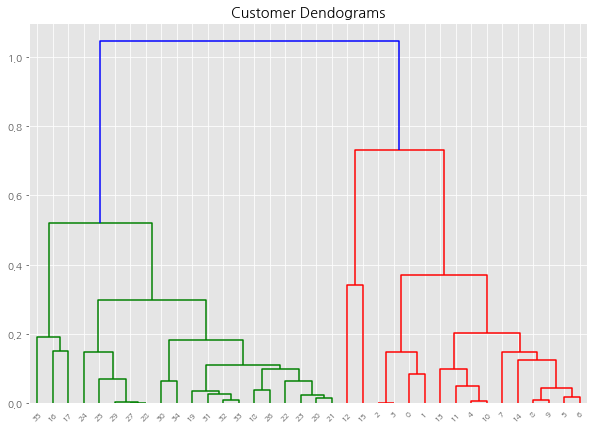

In [731]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(dist, method='complete'))

In [732]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=30, affinity='euclidean', linkage='average')
cluster.fit_predict(dist)

data_parking['comp_clus']=pd.DataFrame(cluster.fit_predict(dist))

C:\Users\Cho Gyung Ah\Anaconda3\lib\site-packages\sklearn\cluster\hierarchical.py:471: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
C:\Users\Cho Gyung Ah\Anaconda3\lib\site-packages\sklearn\cluster\hierarchical.py:471: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


In [733]:
comp_top_parking=data_parking.groupby(['comp_clus','자치구','동','주차장명']).agg({'sum1':'mean','총_점수_interval_10':'mean'})

comp_index=comp_top_parking.sort_values(by='sum1', ascending=False).groupby('comp_clus').head(1)

In [734]:
top_pk_index = comp_index.index.get_level_values('주차장명').tolist()

In [735]:
top_parking = data_parking[(data_parking.주차장명.isin(top_pk_index))]

In [736]:
geo_path = "geoData_copy.json"
geo_str = json.load(open(geo_path, encoding="utf-8"))

seoul_map = folium.Map(location=[37.5502, 126.982], zoom_start=10.5, tiles="cartodbpositron")
seoul_map.choropleth(geo_data=geo_str, 
                     data = data_total_gas_pk ,
                     columns=['동', 'sum1'],
                     fill_color='RdPu',  # GnBu
                     key_on='properties.name',
                     highlight=True,
                     fill_opacity=0.5,
                     line_opacity=1,
                     legend_name="sum1")

C:\Users\Cho Gyung Ah\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [737]:
top_parking.reset_index(drop=True, inplace=True)

In [738]:
for i in range(len(top_parking)):
    folium.Marker(
        location=top_parking.loc[i,['주차위도','주차경도']],
        popup=top_parking.loc[i,['동']],
        icon=folium.Icon(color='gray')
    ).add_to(seoul_map)

for i in range(len(top_data)):
    folium.Marker(
        location=top_data.loc[i,['경도','위도']],
        popup=top_data.loc[i,['동']],
        icon=folium.Icon(color='lightgray',icon='home')
    ).add_to(seoul_map)
    
    
# 양재 수소충전소를 찍어보자.
folium.Marker(
  location=[37.4686275,127.0319203],
  popup='양재 수소 충전소 위치.',
  icon=folium.Icon(color='red',icon='star')
).add_to(seoul_map)

# 상암 수소 충전소를 찍어보자.
folium.Marker(
  location=[37.5687204,126.8761933],
  popup='상암 수소 충전소 위치.',
  icon=folium.Icon(color='red',icon='star')
).add_to(seoul_map)

# 국회 수소 충전소를 찍어보자.
folium.Marker(
  location=[37.5311111,126.9132037],
  popup='2019년 완공 예정 국회 수소 충전소 위치.',
  icon=folium.Icon(color='blue',icon='star')
).add_to(seoul_map)

# 강동구 상일충전소를 찍어보자.
folium.Marker(
  location=[37.5392486,127.128611],
  popup='2019년 완공 예정 강동구 상일충전소 위치',
  icon=folium.Icon(color='blue',icon='star')
).add_to(seoul_map)

# 강서공영차고지 수소생산기지 찍어보자.
folium.Marker(
  location=[37.5775641,126.7963879],
  popup=' 2020년 완공 예정 강서공영차고지 수소생산기지 버스용',
  icon=folium.Icon(color='green',icon='star')
).add_to(seoul_map)

# 탄천물재생센터 수소춘전소 찍어보자.
folium.Marker(
  location=[37.4915688,127.0671297],
  popup=' 2020년 완공 예정이지만 미정 탄천물재생센터 수소춘전소',
  icon=folium.Icon(color='green',icon='star')
).add_to(seoul_map)

# 현대자동차 계동사옥 수소춘전소 찍어보자.
folium.Marker(
  location=[37.566758,126.9584211],
  popup=' 아직 미정 현대자동차 계동사옥 수소춘전소',
  icon=folium.Icon(color='green',icon='star')
).add_to(seoul_map)

seoul_map

In [836]:
data_total_gas_pk[(data_total_gas_pk.주차장명 == '해공공영주차장' )]

,Unnamed: 0,자치구,동,edu_percent,동별_친환경자동차수,store_총_개소,백화점_개소,합계_사업체수,㎡당 매매평균가,행정구역코드,...,주차운영요일,평일운영시작시각,평일운영종료시각,토요일운영시작시각,토요일운영종료시각,주차요금정보,주차기본시간,주차기본요금,주차경도,주차위도
584,584,강동구,천호2동,31344.760835,292.871548,6.0,1.0,3730,601.0,1125073.0,...,평일+토요일+공휴일,00:00,00:00,00:00,00:00,유료,5.0,150.0,127.128835,37.541035
